In [1]:
! pip install torch torchvision pillow matplotlib numpy opencv-python huggingface-hub

INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/15.5 MB ? eta -:--:--
   ---- ----------------------------------- 1.6/15.5 MB 8.3 MB/s eta 0:00:02
   --------- ------------------------------ 3.7/15.5 MB 9.1 MB/s eta 0:00:02
   -------------- ------------------------- 5.5/15.5 MB 9.1 MB/s eta 0:00:02
   ------------------ --------------------- 7.1/15.5 MB 8.4 MB/s eta 0:00:02
   -------------------- ------------------- 8.1/15.5 MB 7.6 MB/s eta 0:00:01
   ------------------------- -------------- 9.7/15.5 MB 7.6 MB/s eta 0:00:01
   --------------------------- ------------ 10.7/15.5 MB 7.2 MB/s eta 0:00:01
   ----------------------------- ---------- 11.5/15.5 MB 6.8 MB/s eta 0:00:01
   ------------------------------- -------- 12.3/15.5 MB 6.5 MB/s eta 0:00:01
   -------------------------------- ------- 12.6/15.5 MB 6.4 MB/s eta 0:00:01
   ---

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.13 requires opencv-contrib-python, which is not installed.
roboflow 1.1.37 requires opencv-python-headless==4.10.0.84, which is not installed.
manim 0.19.0 requires numpy>=2.1; python_version >= "3.10", but you have numpy 1.26.4 which is incompatible.
mediapipe 0.10.13 requires protobuf<5,>=4.25.3, but you have protobuf 5.29.5 which is incompatible.
tensorflow-intel 2.16.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.29.5 which is incompatible.


In [1]:

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
from torchvision import transforms, models
from huggingface_hub import hf_hub_download


Original image shape: (166, 303, 3)


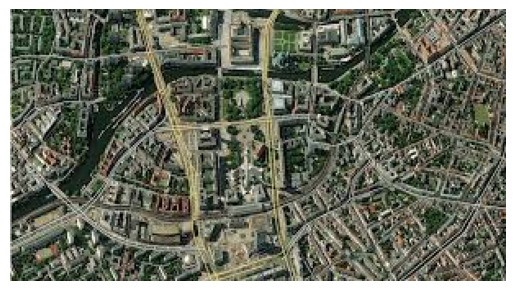

In [4]:
INPUT_IMAGE_PATH = r'C:\Users\sride\OneDrive\Documents\Projects\py\ds\images.jpeg'

orig_bgr = cv2.imread(INPUT_IMAGE_PATH)
if orig_bgr is None:
    raise FileNotFoundError(f"Input image not found: {INPUT_IMAGE_PATH}")
orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)
print('Original image shape:', orig_rgb.shape)

plt.axis('off')  
plt.imshow(orig_rgb)

In [5]:
print('Downloading model weights...')
repo_id = 'Koushim/deeplabv3-resnet50-cityscapes'
model_filename = 'pytorch_model.bin'
model_path = hf_hub_download(repo_id=repo_id, filename=model_filename)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.segmentation.deeplabv3_resnet50(pretrained=False, progress=True, num_classes=19)
state = torch.load(model_path, map_location=device)
if isinstance(state, dict) and 'state_dict' in state:
    model.load_state_dict(state['state_dict'])
else:
    model.load_state_dict(state)
model.to(device)
model.eval()

preprocess = transforms.Compose([
    transforms.Resize((360,720)),
    transforms.ToTensor(),
])

img_pil = Image.fromarray(orig_rgb)
input_tensor = preprocess(img_pil).unsqueeze(0).to(device)

with torch.no_grad():
    out = model(input_tensor)['out']
    probs = torch.softmax(out, dim=1)
    pred = torch.argmax(probs, dim=1).squeeze(0).cpu().numpy()

c:\Users\sride\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sride\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\sride\AppData\Local\Temp\ipykernel_2024\4153697159.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future r

RuntimeError: Error(s) in loading state_dict for DeepLabV3:
	Unexpected key(s) in state_dict: "aux_classifier.0.weight", "aux_classifier.1.weight", "aux_classifier.1.bias", "aux_classifier.1.running_mean", "aux_classifier.1.running_var", "aux_classifier.1.num_batches_tracked", "aux_classifier.4.weight", "aux_classifier.4.bias". 

In [ ]:
road_train_id = 0
road_mask = (cv2.resize(pred, (orig_rgb.shape[1], orig_rgb.shape[0]), interpolation=cv2.INTER_NEAREST) == road_train_id).astype(np.uint8)*255
plt.axis('off')
plt.imshow(road_mask, cmap='gray')

In [ ]:
overlay = orig_rgb.copy()
red = np.array([255,0,0], dtype=np.uint8)
alpha = 0.5
overlay[road_mask==255] = (overlay[road_mask==255] * (1-alpha) + red * alpha).astype(np.uint8)
plt.axis('off')
plt.imshow(overlay)